# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. This is the dataset to use for this assignment. Note: The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

<IPython.core.display.Javascript object>


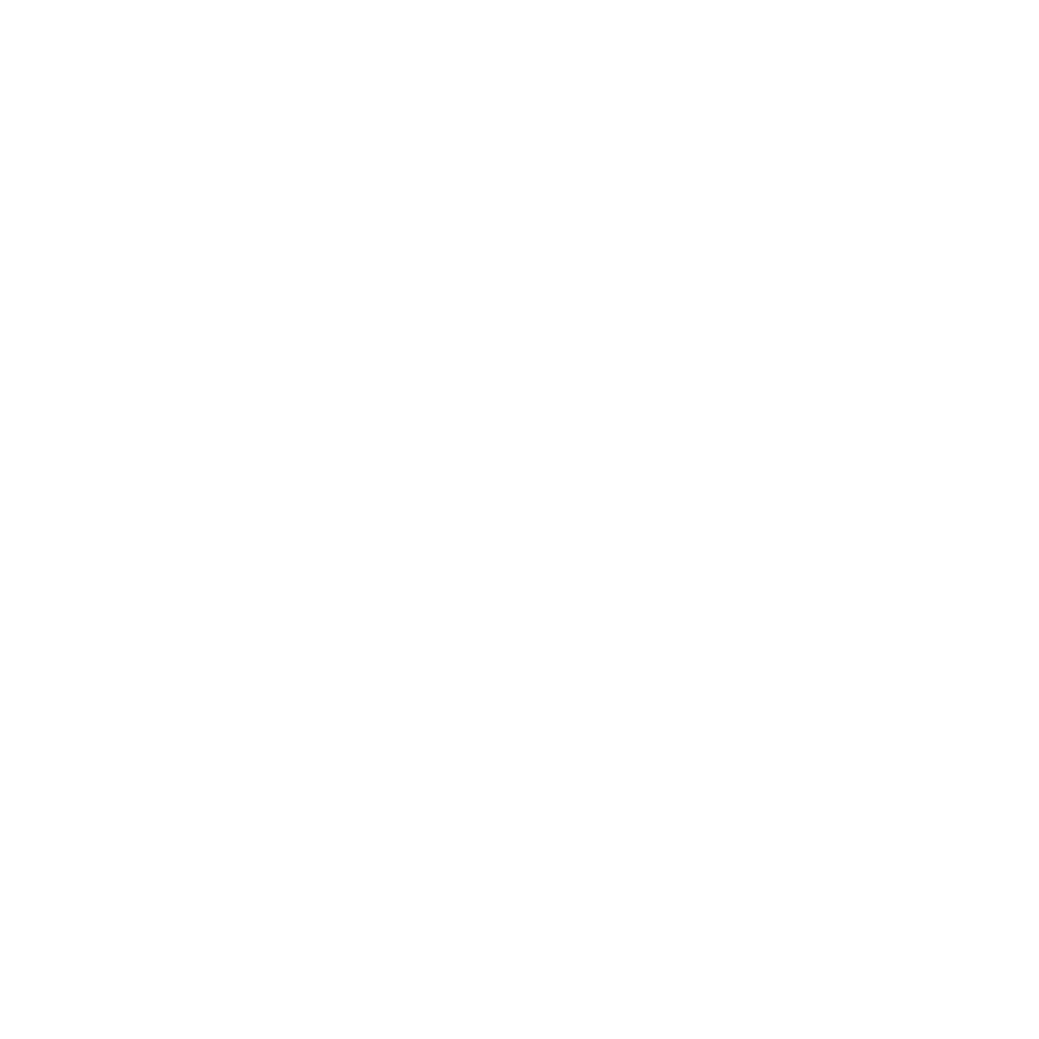

In [12]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')

## Prepare Data

In [13]:
df = pd.read_csv('data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv')

In [14]:

##group temperatures by Date and add Year, Monthy, and Day columns to dataframe
def group_stations(df, aggfunc):
    dff=df.groupby(['Date'], as_index=False).agg({'Data_Value':aggfunc})
    temp = pd.DatetimeIndex(dff['Date'])
    dff['Year'], dff['Month'], dff['Day']=temp.year, temp.month, temp.day
    dp=dff[(dff['Month']==2) & (dff['Day']==29)] 
    return dff.drop(dp.index).drop('Date', axis=1)

def group_years_months(df, aggfunc):
    return df.groupby(['Month', 'Day'], as_index=False).agg({'Data_Value':aggfunc})

#label max and min columns
def maxmin(dfLeft, dfRight, strLabelMax, strLabelMin):
    dff=pd.merge(dfLeft, dfRight, how='inner', on=['Month', 'Day'])
    dff.rename(index=str, columns={'Data_Value_x':strLabelMax, 'Data_Value_y':strLabelMin}, inplace=True)
    dff.set_index(['Month', 'Day'], inplace=True)
    return dff

def prepare():
    df = pd.read_csv('data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv') 
    #create 2 dataframes for Max and Min
    dfmax=df[df['Element']=='TMAX'] 
    dfmin=df[df['Element']=='TMIN']
    #find min-max values per day by all stations
    dfmax=group_stations(dfmax, 'max') 
    dfmin=group_stations(dfmin, 'min')
    #drop 2015 year
    df2015max=dfmax[dfmax['Year']==2015].drop('Year', axis=1) 
    df2015min=dfmin[dfmin['Year']==2015].drop('Year', axis=1)
    dfmax=dfmax.drop(df2015max.index) 
    dfmin=dfmin.drop(df2015min.index)
    #find min-max values per day by each year
    dfmax=group_years_months(dfmax, 'max') 
    dfmin=group_years_months(dfmin, 'min')
    # create 2 dataframes, one for years 2004-2014 and one for 2015
    dfLinesRet=maxmin(dfmax, dfmin, 'Max temp, C', 'Min temp, C')
    dfScatRet=maxmin(df2015max, df2015min, 'Max temp 2015, C', 'Min temp 2015, C')
    return (dfLinesRet, dfScatRet)

In [15]:
dfLines, dfScat=prepare()

## Plotting Data

In [16]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from calendar import month_abbr
from datetime import date, timedelta

<IPython.core.display.Javascript object>


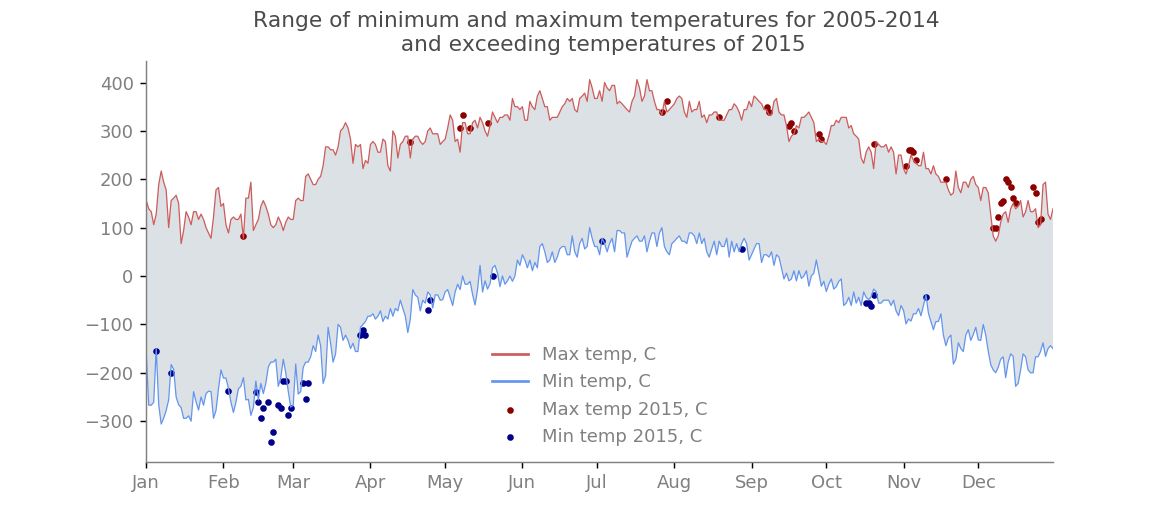

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:24: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


In [34]:
L = list(pd.date_range('1-1-2015', periods=365, freq='D'))
diap_date = [dt.strftime('%b %d') for dt in L]

def plot2lines(dtf):
    #ax1=dfLines.xs(1).plot.line(figsize=(9, 5), use_index=False) # for one month

    dfx=dtf.reset_index()
    x_val=dfx.index.values
    x_ticks=dfx[dfx['Day']==1].index.tolist()

    ax1=dtf.plot.line(x_val, figsize=(9, 4), xticks=x_ticks) # plot 2 lines
    ax1.fill_between(x_val, dtf['Max temp, C'], dtf['Min temp, C'], 
                     facecolor='lightslategrey',
                     alpha=0.25) # fill betwee 2 lines
    return ax1

def format_plot_area(ax1):
    # format plot area
    ax1.spines['bottom'].set_color('grey')
    ax1.spines['left'].set_color('grey')

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_axis_bgcolor('white')
    h, l = ax1.get_legend_handles_labels()
    lines=(h[0], h[1]) #ax1.get_lines()
    h[0].set_color('indianred')
    h[1].set_color('cornflowerblue')
    ax1.legend(h, ('Max 2005-2014', 'Min 2005-2014', 
                   '2015 above Max', '2015 below Min'), loc=0, prop={'size': 1}, frameon=False)
    #mine
    #ax1.legend().get_frame().set_linewidth(0.0)  
    for text in ax1.legend(frameon=False).get_texts():
        text.set_color("grey") 
    ##
    plt.setp(lines, linewidth=0.7)
    ax1.set_xticklabels([s for s in month_abbr if s!='']) # set x-labels
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    ax1.set_title('Range of minimum and maximum temperatures for 2005-2014 \n and exceeding temperatures of 2015', alpha=0.7)
    #ax1.set_ylabel('Temperature, C')
    ##mine
    ax1.tick_params(labelcolor='grey')
    #for text in ax1.legend().get_texts():
    #    text.set_color("grey")
    
def plot_scatter(ax1):
    df=pd.merge(dfLines.reset_index(), dfScat.reset_index(), how='inner')
    df['ind']=df.index
    dfMx=df[df['Max temp 2015, C'] > df['Max temp, C']]
    dfMn=df[df['Min temp 2015, C'] < df['Min temp, C']]

    dfMx.plot.scatter(x='ind', y='Max temp 2015, C', label='Max temp 2015, C', ax=ax1, 
                      color='darkred', s=7)
    dfMn.plot.scatter(x='ind', y='Min temp 2015, C', label='Min temp 2015, C', ax=ax1, 
                      color='darkblue', s=7)
    return ax1

ax1=plot2lines(dfLines)
plot_scatter(ax1)
format_plot_area(ax1)

In [35]:
plt.savefig('vis3.png')